# What we need to define environment:

1: States and possible actions:
-- States I would say is the price (according to different variables), actions should be to buy/sell/hold

2: Transition functions:
-- When do we go from one state to another (How the fuck do we determine this? Do it based on different varibles, e.g. from the news scraper, price, volatility, etc..)

3: Reward function:
-- A reward should be given if the correct decision was made - e.g. we sell and make money, or negative reward if we hold and loose money and so on. Also should we penalize if the subsequent price goes up, even though we sell with a profit? I.e. should the reward then be (profit - potential profit)?

4: Reset and the step function.

NOTES: 
-- Test with different values of alpha, gamma & epsilon - potentially try use the tool that we used in ADL (this costs money though).
-- Use torch to save the model.
-- https://www.kaggle.com/code/shaa2002/minute-level-trading (inspi)

NOTES 2:
-- See if we can utilize RF (from RF_test) & NLP to make the algorithm perform better
-- Potentially have the RF prediction (up/down) in the dataset, i.e. make a new column that the algorithm also uses to make decisions.

In [2]:
# Install necesarry:

import numpy as np
import random
from IPython.display import clear_output
#import gym
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

In [3]:
import os
import math

# Make a folder for the saved models:

current_directory = os.getcwd()

models_folder = current_directory + "/models"
os.makedirs(models_folder, exist_ok=True)

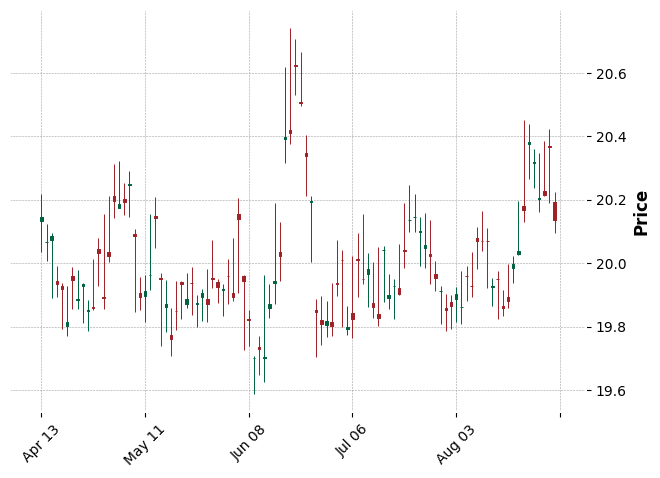

,slug,open,high,low,close,currency
date,,,,,,
2021-04-13,USD/MXN,20.134001,20.217951,20.035299,20.144430,MXN
2021-04-14,USD/MXN,20.067200,20.125280,20.006300,20.067499,MXN
2021-04-15,USD/MXN,20.073099,20.095461,19.891500,20.086060,MXN
2021-04-16,USD/MXN,19.944651,19.989950,19.894400,19.935900,MXN
2021-04-19,USD/MXN,19.929600,19.936550,19.791800,19.918301,MXN


In [4]:
# mplfinance - matplotlib utilities for the visualization, and visual analysis, of financial data
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

# Call it as:  mpf.plot(data) -- where data is a Pandas DataFrame object containing Open, High, Low and Close data, with a Pandas Datetime Index

# Dataset: https://www.kaggle.com/datasets/dhruvildave/currency-exchange-rates

# Get dataset:
data = pd.read_csv("data/forex.csv")
plot_data = data[-100:].copy() # Last 100 elements of the sequence (index)

# Convert datetime column to datetime format
plot_data['date'] = pd.to_datetime(plot_data['date'])

# Create a DataFrame with datetime as index
df = pd.DataFrame(plot_data)
df.set_index('date', inplace=True)

# Plot candlestick chart
mpf.plot(df, type='candle', style='charles', volume=False)

df.head()

In [5]:
data.shape

(1453035, 7)

In [7]:
plot_data = data

# Convert datetime column to datetime format
plot_data['date'] = pd.to_datetime(plot_data['date'])

# Create a DataFrame with datetime as index
df = pd.DataFrame(plot_data)
# df.set_index('datetime', inplace=True)

# # Calculate gap up and gap down events
# prev_close = df['close'].shift(1)
# df['gap_up'] = df['open'] > prev_close
# df['gap_down'] = df['open'] < prev_close

# calculate partial and full gap up/down separately
# Calculate gap up and gap down events
prev_datetime = df['date'].shift(1)
prev_close = df['close'].shift(1)
prev_high = df['high'].shift(1)
prev_low = df['low'].shift(1)

gap_up_diff = df['open'] - prev_close
gap_down_diff = prev_close - df['open']

# Define threshold for significant gap
threshold = 0.04  # Adjust as needed

df['is_next_day'] = (prev_datetime.dt.date != df['date'].dt.date)

# Partial gap up/down
df['partial_gap_up'] = df['is_next_day'] & (gap_up_diff > 0) & (df['open'] < prev_high) & (gap_up_diff > threshold)
df['partial_gap_down'] = df['is_next_day'] & (gap_down_diff > 0) & (df['open'] < prev_low) & (gap_down_diff > threshold)

# Full gap up/down
df['full_gap_up'] = df['is_next_day'] & (df['open'] > prev_high)
df['full_gap_down'] = df['is_next_day'] & (df['open'] < prev_low)

# Calculate gap sizes (absolute and percentage)
df['gap_size_abs'] = gap_up_diff
df['gap_size_pct'] = (gap_up_diff / df['close']) * 100

# Print DataFrame with gap up/down events
df.head(20)

,slug,date,open,high,low,close,currency,is_next_day,partial_gap_up,partial_gap_down,full_gap_up,full_gap_down,gap_size_abs,gap_size_pct
0,GBP/EGP,2001-04-10,5.58090,5.59470,5.59470,5.59470,EGP,True,False,False,False,False,NaN,NaN
1,GBP/EGP,2001-06-04,5.47517,5.49390,5.49390,5.49390,EGP,True,False,True,False,True,-0.11953,-2.175686
2,GBP/EGP,2001-08-01,5.67990,5.65430,5.65430,5.65430,EGP,True,False,False,True,False,0.18600,3.289532
3,GBP/EGP,2002-07-29,7.21700,7.21700,7.21700,7.21700,EGP,True,False,False,True,False,1.56270,21.653041
4,GBP/EGP,2003-01-02,7.42429,7.38990,7.38990,7.38990,EGP,True,False,False,True,False,0.20729,2.805045
5,GBP/EGP,2003-04-21,9.29241,9.25045,9.25045,9.25045,EGP,True,False,False,True,False,1.90251,20.566675
6,GBP/EGP,2004-02-13,11.60700,11.64200,11.52000,11.57800,EGP,True,False,False,True,False,2.35655,20.353688
7,GBP/EGP,2004-02-16,11.57100,11.62300,11.49900,11.60700,EGP,True,False,False,False,False,-0.00700,-0.060308
8,GBP/EGP,2004-02-17,11.60800,11.73900,11.52100,11.66200,EGP,True,False,False,False,False,0.00100,0.008575
9,GBP/EGP,2004-02-18,11.67700,11.77200,11.63100,11.69100,EGP,True,False,False,False,False,0.01500,0.128304
